# Comparison of Classifier Algorithms
Various classification algorithms are compared here for a data set. This dataset on past loans is from the IBM certification course. The following classifier algorithms are used to predict good/bad loans using the dataset.
- Logistic regression
- K Nearest Neighbours
- Decision Tree
- Support Vector Machines

Train and test data are provided in two different files. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount.                                                          |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of the applicant                                                            |
| Gender         | Gender of the applicant                                                               |

In [2]:
# Load basic modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import itertools
%matplotlib inline
from sklearn.model_selection import train_test_split

In [3]:
# Load classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [4]:
# Load evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn import metrics
from sklearn import tree

In [5]:
# Loading data
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0.1,Unnamed: 0,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


### Exploratory data analysis & Pre-processing

In [6]:
print(df.shape)
df.isnull().sum()

(346, 10)


Unnamed: 0.1      0
Unnamed: 0        0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

There is no missing information in the dataset. The first two columns are not relevant to the problem and are dropped.

In [7]:
df.pop('Unnamed: 0.1')
df.pop('Unnamed: 0')
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


The effective and due dates are converted to _datetime_ objects.

In [8]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


In [9]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection (defaulters). There is a disporportionately high number of data points in one particular class which may affect the prediction models.

Let us try to make some preliminary inferences using pairplots.

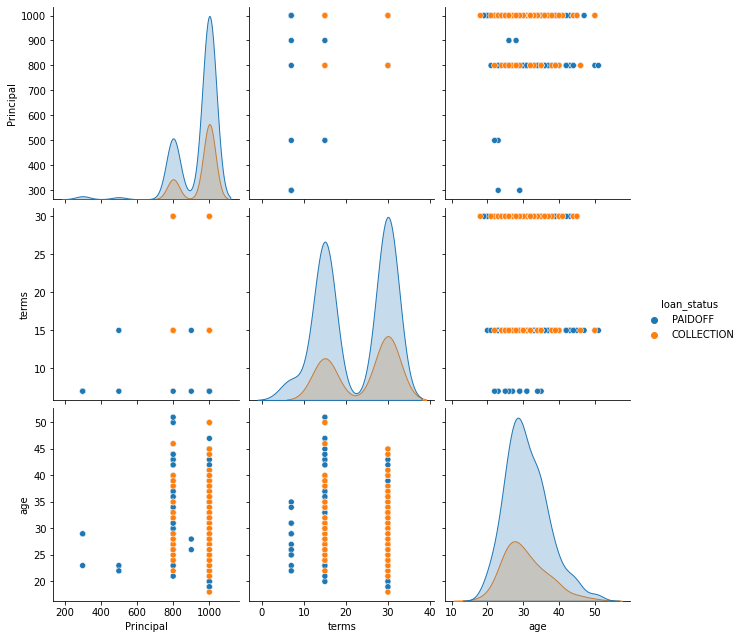

In [10]:
sns.pairplot(df,hue='loan_status',height=3)

The pairplot highlights the importance of continuous variables - principal, terms and age. Loans for a principal amount less than 800 are good loans. Short-term loans (7 days), irrespective of the amount, are good loans. Long term loans of  higher principal are bad loans. 

We can also try to infer the effects of discrete variables - gender, education and effective/due dates. 
##### Gender
We can look at the data grouped by gender and principal amount.

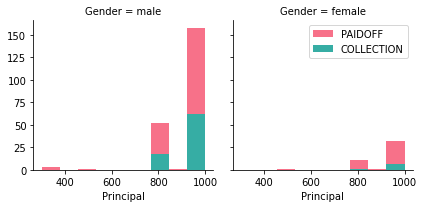

In [11]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="husl", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins)
g.axes[-1].legend()
plt.show()

The figure may suggest that men are more likely to default. But this inference is not conclusive because it appears that there are more men in the dataset. We can look at the percentage of men & women who defults.

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males paid off. The gender variable is converted to 0s and 1s.

In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0


##### Effective date
Let us check if the repayment depends on effective date or the day of the week in which loan comes into effect.

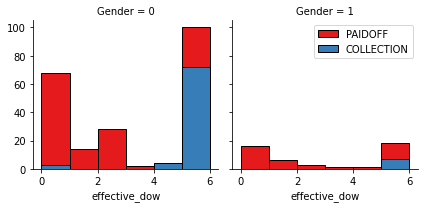

In [14]:
df['effective_dow'] = df['effective_date'].dt.dayofweek
bins = np.sort(df['effective_dow'].unique())
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'effective_dow', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

Pandas _dayofweek_ function finds the day of the week for a given date object with _0_ indicating Monday and _6_ for Sunday. The plot reveals that loans granted during the weekend are more likely to be bad loans. We can use a discrete feature, _weekend_ , to indicate this.

In [15]:
df['weekend'] = df['effective_dow'].apply(lambda x: 1 if (x>4)  else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,effective_dow,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,0


##### Due date
A similar approach can be used for loan due date feature.

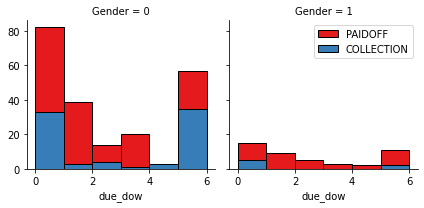

In [16]:
df['due_dow'] = df['due_date'].dt.dayofweek
bins = np.sort(df['due_dow'].unique())
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'due_dow', bins=bins, ec="k")
g.axes[1].legend()
plt.show()

Unlike in the case of effective date, a clear pattern is not immediately evident here.

##### Education
Let us now look at the last discrete variable.

In [17]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Although a clear influence is not clear, we shall retain these variables and create dummies. We shall use these along with principal,terms, age, gender and weekend as features to train the models. 

#### Features

In [18]:
X = df[['Principal','terms','age','Gender','weekend']]
X = pd.concat([X,pd.get_dummies(df['education'])], axis=1)
features = X.columns

#### Label

In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

#### Feature scaling
Most of the features have discrete values 0 or 1. We shall scale the ther features to have values in the range [0,1].

In [20]:
X['Principal']=(X['Principal']-X.Principal.min())/(X.Principal.max()-X.Principal.min())
X['terms']=(X['terms']-X.terms.min())/(X.terms.max()-X.terms.min())
X['age']=(X['age']-X.age.min())/(X.age.max()-X.age.min())

In [21]:
X=X.values

### Loading test set and pre-processing to match training set

In [22]:
test_df=pd.read_csv('loan_test.csv')
test_df.pop('Unnamed: 0.1')
test_df.pop('Unnamed: 0')
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['effective_dow'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['effective_dow'].apply(lambda x: 1 if (x>4)  else 0)
X_test = test_df[['Principal','terms','age','Gender','weekend']]
X_test = pd.concat([X_test,pd.get_dummies(test_df['education'])], axis=1)
y_test = test_df['loan_status'].values

**Feature Scaling** : This must be done using the training set min and max values as reference

In [23]:
X_test['Principal']=(X_test['Principal']-df.Principal.min())/(df.Principal.max()-df.Principal.min())
X_test['terms']=(X_test['terms']-df.terms.min())/(df.terms.max()-df.terms.min())
X_test['age']=(X_test['age']-df.age.min())/(df.age.max()-df.age.min())
X_test=X_test.values

# Logistic Regression

The GridSearchCV function from sklearn library is used to determine the optimum regularization strenght, which is a hyperparameter.

In [24]:
from sklearn.model_selection import GridSearchCV

In [25]:
parameters ={'C':[0.01,0.1,1]}
LR=LogisticRegression()
LR_cv = GridSearchCV(LR,parameters,cv=5)
LR_cv.fit(X,y)
print("tuned hpyerparameters :(best parameters) ",LR_cv.best_params_)
print("accuracy :",LR_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01}
accuracy : 0.7514699792960663


In [26]:
yhat_LR = LR_cv.predict(X_test)

# First column : P(0)   Second column: P(1)
y_probability_LR = LR_cv.predict_proba(X_test)

Confusion matrix, without normalization
[[ 0 14]
 [ 0 40]]


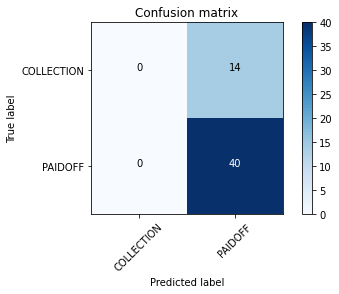

In [29]:
CM_LR= confusion_matrix(y_test, yhat_LR)
plot_confusion_matrix(CM_LR,classes=['COLLECTION','PAIDOFF'])

In [31]:
f1_lr=f1_score(y_test,yhat_LR,pos_label='PAIDOFF')
js_lr=jaccard_score(y_test,yhat_LR,pos_label='PAIDOFF')
print('F1 Score \t: ',np.round(f1_lr,2),'\nJaccard Score \t: ',np.round(js_lr,2))

F1 Score 	:  0.85 
Jaccard Score 	:  0.74


Logistic regression model has Jaccard and F1 scores of 0.74 and 0.85 respectively. This may appear to be a good model from the value. But from the confusion matrix, it can be seen that the model predicts all loans as good loans (PAIDOFF). In that aspect, the model performs very poorly on the training set itself (See below). Nevertheless, the scores are high because of the bias in the original data itself.

Confusion matrix, without normalization
[[  0  86]
 [  0 260]]


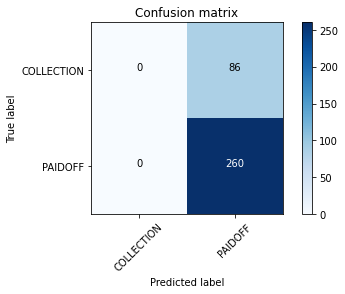

In [32]:
CM_LR= confusion_matrix(y, LR_cv.predict(X))
plot_confusion_matrix(CM_LR,classes=['COLLECTION','PAIDOFF'])

# Decision Tree


For the decision tree model we have to choose many hyperparameters. The _GridSearchCV_ option is made use of to determine the best combination of hyperparameters.
- criterion : measure the quality of split
- splitter : strategy (best or random split)
- maximum depth of the tree
- minimum number of samples required to split an internal node 

In [41]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,7)],
     'min_samples_split': [2, 5, 10]}
DT=DecisionTreeClassifier()
DT_cv = GridSearchCV(DT,parameters,cv=10)
DT_cv.fit(X,y)
print("tuned hpyerparameters :(best parameters) ",DT_cv.best_params_)
print("accuracy :",DT_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'gini', 'max_depth': 2, 'min_samples_split': 2, 'splitter': 'best'}
accuracy : 0.7515966386554622


Confusion matrix, without normalization
[[ 0 14]
 [ 0 40]]


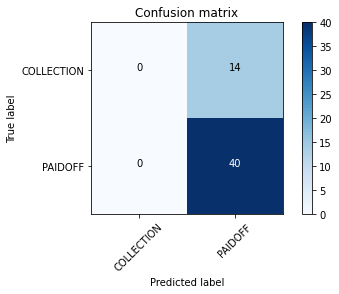

In [42]:
yhat_DTC = DT_cv.predict(X_test)
CM_DTC= confusion_matrix(y_test, yhat_DTC)
plot_confusion_matrix(CM_DTC,classes=['COLLECTION','PAIDOFF'])

In [43]:
f1_dt=f1_score(y_test,yhat_DTC,pos_label='PAIDOFF')
js_dt=jaccard_score(y_test,yhat_DTC,pos_label='PAIDOFF')
print('F1 Score \t: ',np.round(f1_dt,2),'\nJaccard Score \t: ',np.round(js_dt,2))

F1 Score 	:  0.85 
Jaccard Score 	:  0.74


The scores are same as that of the logistic regression classifier.

# Support Vector Machine


GridSearchCV is employed to determine the hyperparameters.
- kernel type
- kernal coefficient (gamma)
- strength of regularization

In [55]:
parameters = {'kernel':('linear', 'rbf','poly', 'sigmoid'),
              'C': np.logspace(-2, 2, 5)}#,
              #'gamma':np.logspace(-2, 2, 5)}
svm = SVC()
SVM_cv = GridSearchCV(svm,parameters,cv=5)
SVM_cv.fit(X,y)
print("tuned hpyerparameters :(best parameters) ",SVM_cv.best_params_)
print("accuracy :",SVM_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'kernel': 'linear'}
accuracy : 0.7514699792960663


We choose degree=5 based on the plot above.

Confusion matrix, without normalization
[[ 0 14]
 [ 0 40]]


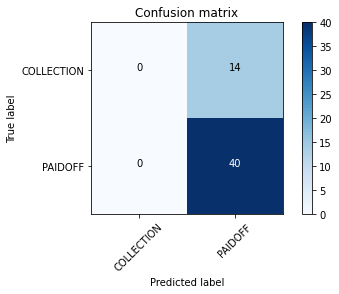

In [54]:
yhat_SVM = SVM_cv.predict(X_test)
CM_SVM= confusion_matrix(y_test, yhat_SVM)
plot_confusion_matrix(CM_SVM,classes=['COLLECTION','PAIDOFF'])

In [56]:
f1_sv=f1_score(y_test,yhat_SVM,pos_label='PAIDOFF')
js_sv=jaccard_score(y_test,yhat_SVM,pos_label='PAIDOFF')
print('F1 Score \t: ',np.round(f1_sv,2),'\nJaccard Score \t: ',np.round(js_sv,2))

F1 Score 	:  0.85 
Jaccard Score 	:  0.74


The support vector machine model has the same scores.

# K Nearest Neighbour(KNN)
For the nearest neighbours model too, the hyperparameters, including _k_, are to be determined. Other hyperparameters are:
- algorithm to compute proximity
- power parameter (L1 or L2)

In [44]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()
KNN_cv = GridSearchCV(KNN,parameters,cv=5)
KNN_cv.fit(X,y)
print("tuned hpyerparameters :(best parameters) ",KNN_cv.best_params_)
print("accuracy :",KNN_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2}
accuracy : 0.7054244306418219


The maximum accuracy is for 7 neighbours. 

Confusion matrix, without normalization
[[ 4 10]
 [ 3 37]]


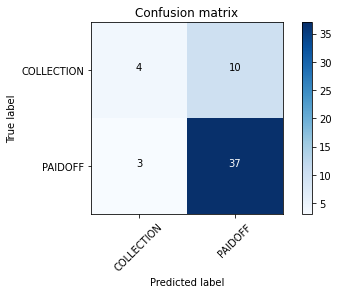

In [45]:
yhat_KNN = KNN_cv.predict(X_test)
CM_KNN= confusion_matrix(y_test, yhat_KNN)
plot_confusion_matrix(CM_KNN,classes=['COLLECTION','PAIDOFF'])

In [46]:
f1_kn=f1_score(y_test,yhat_KNN,pos_label='PAIDOFF')
js_kn=jaccard_score(y_test,yhat_KNN,pos_label='PAIDOFF')
print('F1 Score \t: ',np.round(f1_kn,2),'\nJaccard Score \t: ',np.round(js_kn,2))

F1 Score 	:  0.85 
Jaccard Score 	:  0.74


Although the scores are same as that for other models, we can see that KNN model does not predict a single class always.

## Summary

Since all the models have the same score, the KNN model is chosen because it does not predict a single class. The final model is created by training with full training data, with the optimum parameters.

In [60]:
KNN = KNeighborsClassifier(algorithm='auto',n_neighbors=7,p=2)
KNN.fit(X,y)
KNN.score(X_test,y_test)

0.7592592592592593

Confusion matrix, without normalization
[[ 4 10]
 [ 3 37]]


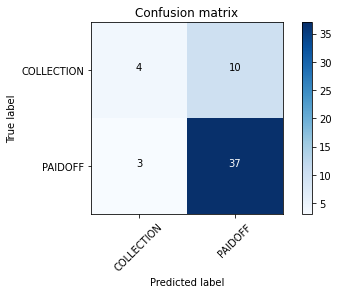

In [61]:
plot_confusion_matrix(confusion_matrix(y_test, KNN.predict(X_test)),classes=['COLLECTION','PAIDOFF'])

##### Functions

In [28]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')